In [2]:
import pandas as pd

# Dokumentácia

## Motivácia

Našou témou bude veľmi častá úloha v oblasti NLP (Natural language processing), konkrétne analýza sentimentu. Na začiatok by sme chceli natrénovať modely na binárnu klasifikáciu používateľských recenzií k filmom. Keďže klasifikácia recenzií je pomerne jednoduchá úloha, poskytuje nám široké možnosti experimentovania a priestor na pridanie rôznych rozšírení k zadaniu.

Analýza sentimentu (známa aj ako prieskum názorov, opinion mining) je oblasťou aktívneho výskumu v oblasti spracovania prirodzeného jazyka. Zameriava sa na identifikáciu, získavanie a organizovanie sentimentov z textov generovaných používateľmi v sociálnych sieťach, blogoch alebo recenziách produktov vie nám povedať, čo si ľudia myslia o danom produkte. Práve kvôli tomu má široké využitie hlavne pre firmy, ktoré sa snažia prispôsobiť svôj produkt pre zákazníkov alebo sa sústreďujú na user experiance.

Analyzovať tisíce recenzií manuálne je časovo aj finančne náročné. Na pomoc prichádza AI a jeho podoblasť NLP, ktorá sa už viacero rokov zaoberá analýzou sentimentu. Oproti iným metódam, neurónové siete majú tú vyhodu, že sa dokážu pomerne jednoducho prispôsobiť danej doméne. Nerobia im problémy ani skratky alebo slang. Navyše sa nám téma javí ako zaujímavá z dôvodu nášho záujmu o filmy, práca na tejto téme je pre nás o to zábavnejšia.

## Podobné práce

Veľmi jednoduchým riešením je použitie rekurentných sietí, ktoré sú na túto úlohu ako stvorené.

-	Graves, Alex. "Supervised sequence labelling with recurrent neural networks. 2012." URL https://www.cs.toronto.edu/~graves/preprint.pdf (2012).

Existuje však mnoho rozšírení, ktoré je možné aplikovať aj v našej práci napr. mechanizmy pozornosti alebo konvolučné siete.

-	Olah, Chris, and Shan Carter. "Attention and augmented recurrent neural networks." Distill 1.9 (2016): e1.
-	Zhang, Xiang, Junbo Zhao, and Yann LeCun. "Character-level convolutional networks for text classification." Advances in neural information processing systems. 2015.
-	Zhang, Lei, Shuai Wang, and Bing Liu. "Deep learning for sentiment analysis: A survey." Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery 8.4 (2018): e1253.
-	Tang, Duyu, Bing Qin, and Ting Liu. "Deep learning for sentiment analysis: successful approaches and future challenges." Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery 5.6 (2015): 292-303.
- Lin, Zhouhan, et al. "A structured self-attentive sentence embedding." arXiv preprint arXiv:1703.03130 (2017).
- M. Akhtar, A. Ekbal, S. Narayan and V. Singh, "No, That Never Happened!! Investigating Rumors on Twitter" in IEEE Intelligent Systems, vol. 33, no. 05, pp. 8-15, 2018.

## Dataset

In [3]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

test_df.drop(columns=['Unnamed: 0'], inplace = True)
train_df.drop(columns=['Unnamed: 0'], inplace = True)

Náš dataset sa skladá z dvoch časti - trénovacej sady a testovacej sady. Obe sady majú 25 000 záznamov, pričom polovica je vždy označená ako negatívne a druhá polovica ako pozitívne.

### Náhľad dát

In [4]:
test_df.head()

,review_text,sentiment
0,A strange relationship between a middle-aged w...,pos
1,Yesterday was one of those days we decided to ...,neg
2,"This movie was rented for free, I had no misco...",neg
3,This is one of Chaplin's First National films ...,pos
4,"I enjoyed Ramin Bahrani's Man Push Cart, and t...",pos


In [5]:
train_df.head()

,review_text,sentiment
0,I really enjoyed watching this movie about the...,pos
1,i saw this film by accident and this movie was...,neg
2,To bad for this fine film that it had to be re...,pos
3,"A clever, undeniably entertaining romp starrin...",pos
4,"I recently rented this doc, having remembered ...",pos


Dáta sa skladajú z dvoch atribútov - review text a sentiment. Prvý atribút **review_text** obsahuje celú textovú recenziu, druhý atribút **sentiment** označuje či je recenzia pozitívna (pos), alebo negatívna (neg).

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
review_text    25000 non-null object
sentiment      25000 non-null object
dtypes: object(2)
memory usage: 390.8+ KB


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
review_text    25000 non-null object
sentiment      25000 non-null object
dtypes: object(2)
memory usage: 390.8+ KB


In [8]:
test_df.describe()

,review_text,sentiment
count,25000,25000
unique,24801,2
top,Loved today's show!!! It was a variety and not...,pos
freq,5,12500


In [9]:
train_df.describe()

,review_text,sentiment
count,25000,25000
unique,24904,2
top,You do realize that you've been watching the E...,pos
freq,3,12500


### Počet pozitívnych a negatívnych recenzií v dátach

In [10]:
test_df['sentiment'].value_counts()

pos    12500
neg    12500
Name: sentiment, dtype: int64

In [11]:
train_df['sentiment'].value_counts()

pos    12500
neg    12500
Name: sentiment, dtype: int64

### Prekrývajúce sa dáta

In [12]:
overlap = train_df.isin(test_df)
overlap[overlap['review_text'] == True]

,review_text,sentiment


Zistili sme, že v našich dátach sa nenachádzajú žiadne riadky, ktoré by boli aj v trénovacích dátach aj v testovacích.

### Tokenizácia

In [13]:
import tensorflow as tf

In [14]:
def get_tokenizer(vocab_file, vocab_size, separator='\n'):
    vocab = open(vocab_file).read()
    tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, split=separator, oov_token=1)
    tokenizer.fit_on_texts([vocab])
    return tokenizer

tokenizer = get_tokenizer('dataset/aclImdb/imdb.vocab', 10001)

### Metriky pre recenzie

In [15]:
test_df['review_text'].str.len().describe()

count    25000.00000
mean      1293.79240
std        975.90776
min         32.00000
25%        696.00000
50%        962.00000
75%       1572.00000
max      12988.00000
Name: review_text, dtype: float64

In [16]:
train_df['review_text'].str.len().describe()

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: review_text, dtype: float64

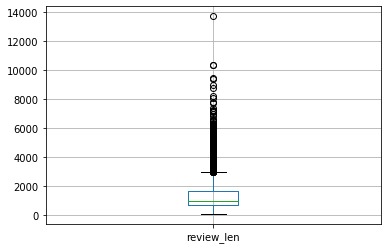

In [19]:
lengths = pd.DataFrame(train_df['review_text'].str.len())
lengths.rename(columns={"review_text": "review_len"}, inplace=True)
lengths
lengths.boxplot(column=['review_len'])

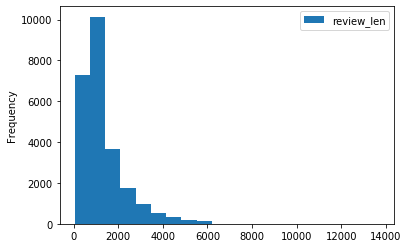

In [18]:
lines = lengths.plot.hist(bins=20)

### Histogram frekvencie slov

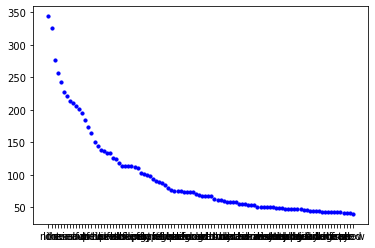

In [24]:
import json
data = json.loads(tokenizer.to_json())
data = json.loads(data["config"]["word_counts"])

words = [key for key, value in data.items()]
counts = [value for key, value in data.items()]

data = list(zip(words, counts))
data = sorted(data, key=lambda d: d[1], reverse=True)

words = [d[0] for d in data]
counts = [d[1] for d in data]

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.scatter(
    words[:100],
    counts[:100],
    color="blue",
    s=10
  )
plt.show()

## Dáta

In [2]:
# Download dataset
DATASET_URL = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
DATASET_DIR = 'dataset'
DATASET_FILE_PATH = f'{DATASET_DIR}/aclImdb_v1.tar.gz'

if not os.path.isfile(DATASET_FILE_PATH):
    print(f'Downloading dataset into {DATASET_FILE_PATH} ...')
    with urllib.request.urlopen(DATASET_URL) as response, open(DATASET_FILE_PATH, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
else:
    print('Dataset already downloaded.')

Dataset already downloaded.


In [3]:
# Untar the dataset archive
if not os.path.isdir(f'{DATASET_DIR}/aclImdb'):
    with tarfile.open(DATASET_FILE_PATH) as archive:
        print(f'Extracting "{DATASET_FILE_PATH}" to "{DATASET_DIR}" ...')
        archive.extractall(DATASET_DIR)
        print('Extraction finished.')
else:
    print('Dataset already extracted.')

Dataset already extracted.


In [4]:
# Arguments
VOCAB_SIZE = 10_000
MAX_SENTENCE_LEN = 300
BATCH_SIZE = 256

In [5]:
# Load data from folders
TEST_FOLDER = f'{DATASET_DIR}/aclImdb/test'
TEST_POSITIVE_FOLDER = f'{TEST_FOLDER}/pos'
TEST_NEGATIVE_FOLDER = f'{TEST_FOLDER}/neg'

TRAIN_FOLDER = f'{DATASET_DIR}/aclImdb/train'
TRAIN_POSITIVE_FOLDER = f'{TRAIN_FOLDER}/pos'
TRAIN_NEGATIVE_FOLDER = f'{TRAIN_FOLDER}/neg'
TRAIN_UNSUPERVISED_FOLDER = f'{TRAIN_FOLDER}/unsup'

In [6]:
def get_tokenizer(vocab_file, vocab_size, separator='\n'):
    vocab = open(vocab_file).read().split(separator)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, oov_token=vocab_size)
    tokenizer.fit_on_texts(vocab)
    return tokenizer

tokenizer = get_tokenizer(f'{DATASET_DIR}/aclImdb/imdb.vocab', VOCAB_SIZE+1)

## Predspracovanie
Používali sme dva druhy predspracovanie jeden pre hierarchické modely, ktorý nám reviews rozdelil na vety a druhý pre baseline modely ktorý nám z celého review spravil trénovaciu vzorku.

In [ ]:
def create_hierarchical_labeled_dataset_from_files(folders, label_map={'pos':[1, 0], 'neg': [0, 1]}, shuffle=True):
    files = map(lambda folder: [glob.glob(f'{folder}/*'), f'{folder}'], folders)

    # Assign label to every files based on folder they are in
    labeled_files = map(lambda files_with_label:
                        map(lambda file_path:
                            [file_path, files_with_label[1].split('/')[-1]] # Take only the last folde from the folder path
                        , files_with_label[0])
                    , files)

    # flatten list
    flat_labeled_files = []
    for lf in labeled_files:
        for fl in lf:
            flat_labeled_files.append(fl)

    if shuffle:
        random.shuffle(flat_labeled_files)

    # read file contents
    labeled_texts = map(lambda example: [
        list(map(lambda x:
                 [x for x in
                     list(filter(None, x.translate({ord(c): None for c in '\'\"()?/\<>!@#$,;'})
                             .lower()
                             .split(' ')))[:MAX_SENTENCE_LEN]
                  if x
                  ],
                 open(example[0]).read().split('.'))),
        example[1]
    ], flat_labeled_files)

    labeled_tokens = map(lambda example: [tf.keras.preprocessing.sequence.pad_sequences(
                                                tokenizer.texts_to_sequences(example[0]), MAX_SENTENCE_LEN, padding='post'),
                                            label_map[example[1]]], labeled_texts)

    return list(labeled_tokens), len(flat_labeled_files)

cls_test_ds, num_test_samples = create_hierarchical_labeled_dataset_from_files([f'{TEST_POSITIVE_FOLDER}', f'{TEST_NEGATIVE_FOLDER}'])
cls_train_ds, num_train_samples = create_hierarchical_labeled_dataset_from_files([f'{TRAIN_POSITIVE_FOLDER}', f'{TRAIN_NEGATIVE_FOLDER}'])


# generate examples in the form of ((bs, review)(bs, label))
def cls_test_gen():
    for el in cls_test_ds:
        yield (el[0][:MAX_PAR_LEN], el[1])


def cls_train_gen():
    for el in cls_train_ds:
        yield (el[0][:MAX_PAR_LEN], el[1])


ds_test = tf.data.Dataset.from_generator(lambda: cls_test_gen(),
                                        (tf.int64, tf.int64)).repeat()
ds_train = tf.data.Dataset.from_generator(lambda: cls_train_gen(),
                                        (tf.int64, tf.int64)).repeat()

ds_train = ds_train.padded_batch(
    BATCH_SIZE,
    padded_shapes=([MAX_PAR_LEN, None], [2]),
    drop_remainder=True)

ds_test = ds_test.padded_batch(
    BATCH_SIZE,
    padded_shapes=([MAX_PAR_LEN, None], [2]),
    drop_remainder=True)

In [8]:
def create_labeled_dataset_from_files(folders, label_map={'pos':[1, 0], 'neg': [0, 1]}, shuffle=True):
    files = map(lambda folder: [glob.glob(f'{folder}/*'), f'{folder}'], folders)

    # Assign label to every files based on folder they are in
    labeled_files = map(lambda files_with_label:
                        map(lambda file_path:
                            [file_path, files_with_label[1].split('/')[-1]] # Take only the last folde from the folder path
                        , files_with_label[0])
                    , files)

    # flatten list
    flat_labeled_files = []
    for lf in labeled_files:
        for fl in lf:
            flat_labeled_files.append(fl)

    if shuffle:
        random.shuffle(flat_labeled_files)

    # read file contents
    labeled_texts = map(lambda example: [open(example[0]).read().split(' ')[:MAX_SENTENCE_LEN], example[1]], flat_labeled_files)

    # tokenize texts
    labeled_tokens = map(lambda example: [*tokenizer.texts_to_sequences([example[0]]),
                                          label_map[example[1]]], labeled_texts)
    return list(labeled_tokens), len(flat_labeled_files)

cls_test_ds, num_test_samples = create_labeled_dataset_from_files([f'{TEST_POSITIVE_FOLDER}', f'{TRAIN_NEGATIVE_FOLDER}'])
cls_train_ds, num_train_samples = create_labeled_dataset_from_files([f'{TRAIN_POSITIVE_FOLDER}', f'{TRAIN_NEGATIVE_FOLDER}'])

def cls_test_gen():
    for el in cls_test_ds:
        yield (el[0], el[1])

def cls_train_gen():
    for el in cls_train_ds:
        yield (el[0], el[1])

ds_test = tf.data.Dataset.from_generator(lambda: cls_test_gen(),
                                        (tf.int64, tf.int64)).repeat()
ds_train = tf.data.Dataset.from_generator(lambda: cls_train_gen(),
                                        (tf.int64, tf.int64)).repeat()
ds_train = ds_train.padded_batch(
    BATCH_SIZE,
    padded_shapes=([None], [2]),
    drop_remainder=True)

ds_test = ds_test.padded_batch(
    BATCH_SIZE,
    padded_shapes=([None], [2]),
    drop_remainder=True)

## Architektúry modelov

### Diagram BiLSTM

![BiLSTM](assets/bilstm-diag.png)

Obojsmerná LSTM sieť, ktorá na svôj vstup dostane celé review.

In [ ]:
tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+2, output_dim=emb, mask_zero=True),
    tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm1, dropout=drop1, activation='sigmoid'),
    ),
    tf.keras.layers.Dense(2, activation='softmax')
])

|parameter|value|
|-----|-----|
|embedding size|300|
|dictionary length|10K|
|sequence length in words|300|
|BiLSTM|128 - 512|
|batch size|256|

#### Výsledky trénovania
![name](assets/baseline_bilstm_accuracy.png)        
![name](assets/baseline_bilstm_loss.png) 

Model sa po 5 epochách pretrénoval, pred tým však dosiahol presnosť ~85% na validačnej množine.

### Diagram self-attention

![BiLSTM](assets/attn-diag.png)

In [ ]:
tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+2, output_dim=emb, mask_zero=True),
    tf.keras.layers.LSTM(lstm1, return_sequences=True, dropout=drop1, activation='sigmoid'),
    layers.SelfAttention(size=lstm1//2,
                         num_hops=64,
                         use_penalization=False,
                         model_api='sequential'),
    tf.keras.layers.Dense(2, activation='softmax')
])

![name](assets/baseline_att_accuracy.png)           
![name](assets/baseline_att_loss.png) 

|parameter|value|
|-----|-----|
|embedding size|300|
|dictionary length|10K|
|sequence length in words|300|
|LSTM|128 - 512|
|batch size|256|

### Diagram BiLSTM siete s mechanizmom pozornosti pred rekurentnou vrstvou

![BiLSTM](assets/xxx4-diag.png)

In [ ]:
tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+2, output_dim=emb, mask_zero=True),
    layers.SelfAttention(size=lstm1//2,
                         num_hops=64,
                         use_penalization=False,
                         model_api='sequential'),
    tf.keras.layers.Reshape((-1, 256)),
    tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm1, return_sequences=False, dropout=drop1, activation='sigmoid')),
    tf.keras.layers.Dense(2, activation='softmax')
])

|parameter|value|
|-----|-----|
|embedding size|300|
|dictionary length|10K|
|sequence length in words|300|
|BiLSTM|128 - 512|
|batch size|256|

Self attention mechinizmus bol v tomto prípade použitý nad embeddingami, výsledný vektor bol následne rozdelení a slúžil ako vstup pre BiLSTM vrstvu.
![name](assets/baseline_pre_att_accuracy.png)       
![name](assets/baseline_pre_att_loss.png) 

Validation accuracy

|model name/Hidden units|128|256|512|
|-|-|-|-|
|BiLSTM|0.85|0.84|0.85|
|Attention|0.86|0.85|0.5|
|BiLSTM pre Attention|0.85|0.85|0.85|

### Diagram hierarchickej LSTM siete

![BiLSTM](assets/xxx1-diag.png)

In [ ]:
tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+2, output_dim=emb, mask_zero=True),
        input_shape=(MAX_PAR_LEN, args.sl)),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.LSTM(lstm1, dropout=drop1, activation='sigmoid')),
    tf.keras.layers.LSTM(lstm2, dropout=drop2, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation='softmax')
])

Hierarchická LSTM sieť. Každé review je rozdelené na vety následne LSTM siete vytvoria reprezentáciu viet zo slov. Tieto reprezentácie viet slúžia ako vstup pre ďaľšiu LSTM siet, ktorá vytvára reprezentáciu celého dokunetu ktorý je následne kategorizovaný.

|parameter|value|
|-----|-----|
|embedding size|300|
|dictionary length|10K|
|sequence length in words|20 * 15 sentences in a paragraph|
|LSTM1|128 - 256|
|LSTM2|128 - 512|
|batch size|256|

![name](assets/hierarchical_lstm_accuracy.png)      
![name](assets/hierarchical_lstm_loss.png)

Validation accuracy

|LSTM1/LSTM2|128|256|512|
|-|-|-|-|
|128|0.51|0.51|0.51|
|256|0.5|0.51|0.51|

Ako môžeme vydieť sieť mala problém zovšeobecniť. Fungovala na trénovacej sade ale nie na validačnej.

### Diagram hierarchickej BiLSTM siete

![BiLSTM](assets/xxx3-diag.png)

In [ ]:
tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+2, output_dim=emb, mask_zero=True),
        input_shape=(MAX_PAR_LEN, args.sl)),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm1, dropout=drop1, activation='sigmoid')
        )),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm2, dropout=drop2, activation='sigmoid')
    ),
    tf.keras.layers.Dense(2, activation='softmax')
])

LSTM siete z predchádzajúcej hierarchickej siete boli nahradené BiLSTM sieťami, ktoré vyrišilo problémy s predchádzajúcim modelom.
![name](assets/hierarchical_bilstm_accuracy.png)    
![name](assets/hierarchical_bilstm_loss.png) 

Validation accuracy

|LSTM1/LSTM2|128|256|512|
|-|-|-|-|
|128|0.84|0.84|0.84|
|256|0.84|0.84|0.84|

### Diagram hierarchickej BiLSTM siete s mechanizmom pozortnosti

![BiLSTM](assets/xxx2-diag.png)

In [ ]:
tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+2, output_dim=emb, mask_zero=True),
        input_shape=(MAX_PAR_LEN, args.sl)
    ),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm1, dropout=drop1, activation='sigmoid')
        )
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm2, dropout=drop2, activation='sigmoid', return_sequences=True)
    ),
    layers.SelfAttention(size=lstm2//2,
                         num_hops=32,
                         use_penalization=False,
                         model_api='sequential'),
    tf.keras.layers.Dense(2, activation='softmax')
])

|parameter|value|
|-----|-----|
|embedding size|300|
|dictionary length|10K|
|sequence length in words|20 * 15 sentences in a paragraph|
|BiLSTM1|128 - 256|
|BiLSTM2|128 - 512|
|batch size|256|

![name](assets/hierarchical_bilstm_att_accuracy.png)
![name](assets/hierarchical_bilstm_att_loss.png)

Validation accuracy

|LSTM1/LSTM2|128|256|512|
|-|-|-|-|
|128|0.85|0.84|0.5|
|256|0.86|0.85|0.5|

## Training routine

Všetkých 6 modelov novali 20 epoch s dĺžkou review 300 slov, alebo 20 slov po 15 viet(V prípade hierarchických sietí). Tým pádom, že sme používali optimalizačný algoritmus ADAM nebolo treba menuálne nastavovať learning raty. Batch size bol 256.

Počas trénovania sa ukladal vždy najlepší model. Zložky logs obsahujú celý priebeh trénovania.

Každá sieť sa trénovala s nasledujúcimi parametrami 128, 256 alebo 512 prvkov v skrytých vrstvách.

## Experimenty

Robili sme experiment, v ktorom sme sa snažili analyzovať sentiment používateľských recenzií. Použili sme škálu modelov s rôznymi konfiguráciami vrstiev:
- BiLSTM
- LSTM s mechanizmami pozornosti pred a po LSTM vrstve
- hierarchické LSTM siete s a bez BiLSTM a mechanizmom pozornosti.

Snažili sme sa zistiť ako rôzne hierarchie a počet neurónov v ich rekurentných sietiach ovplyvňuje výsledok trénovania. Dopeli sme k nasledujúcim zisteniam:
- Množstvo neurónov 128, 256, 512 nijakým extrémnym spôsobom neovplyvňoval výkon našich modelov
- Všetky modely(okrem jedného) sa dokázali naučiť klasifikovať review s presnosťou 0.85 percent
- Hierarchický model s LSTM vrstvami mal problém vôbec zovšeobecníť, tento problém zanikol po pridaní BiLSTM vrstvy
- Taktiež mali problémy siete, ktoré mali veľmi veľké vrstvy pozornosti, hierarchické aj baseline s att s 512 neurónmy
- Najrýchlejšie konvergovali hierarchické siete s BiLSTM vrstvami s BiLSTM siete s mechanizmom pozornosti pre rekurentnou vrstvou

Všetky siete mali rovnaký výkon a dosahovali presnosť okolo 0.85, nezávisle od modelu alebo počtu neurónov v ich vrstvách. Sústredili sme sa potom na zistenie toho, ktorý model sa vie natrénovať najrýchlejšie. Najviac sme boli spokojný s BiLSTM s Attentionnom. Najrýchlejšie sa trénoval a nemal problém konvergovať k niečomu užitočnému od začiatku. Najhoršie na tom boli hierarchické neurónové siete s jednosmernou LSTM sieťou. Pravdepodobne kvôli tomu, že nevedeli vytvoriť zmysluplnú reprezentáciu viet.

V prípade, že attention vrstva narástla na veľkosť 256, sieťe mali problém zovšeobecňovať. Attention vrstva ma vždme polovicu veľkosti predchádzajúcej vrstvy.